# Quickstart : 推薦システムのシミュレーション (環境設定)
このノートブックでは推薦システムのシミュレーション環境をカスタマイズする例を紹介します．

特に、以下の3つの順番で解説していきます: 

1. 推薦システムのシミュレーションとオンライン強化学習
2. 標準的な環境設定
3. 環境設定のカスタマイズ


このライブラリは，オンラインとオフラインの方策学習およびモデルベースのオフ方策評価の一部で [d3rlpy](https://github.com/takuseno/d3rlpy)のアルゴリズムを利用しています．

In [2]:
# SCOPE-RL モジュールのインポート
import scope_rl
from scope_rl.policy import OnlineHead

# import recgym modules
from recgym import RECEnv
from recgym import BaseUserModel
from recgym.utils import sigmoid

# d3rlpy アルゴリズムのインポート
from d3rlpy.algos import DiscreteRandomPolicyConfig

# その他のライブラリのインポート
import gym

from sklearn.utils import check_random_state
from sklearn.utils import check_scalar

In [7]:
from dataclasses import dataclass
from typing import Tuple, Union, Optional

import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
# バージョン
print(scope_rl.__version__)

0.1.2


In [5]:
# random stateの設定
random_state = 12345
random_ = check_random_state(random_state)

In [8]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [9]:
# warnings
import warnings
warnings.simplefilter('ignore')

## 1. セットアップ, 人工データの生成とオフライン強化学習
まず初めに推薦システム環境を紹介します．

#### 強化学習での推薦システム環境のセットアップ
推薦システムにおいて, 強化学習エージェントの目的は累積報酬を最大化することです．
この問題を(部分観測)マルコフ決定過程((PO)MDP)として定式化します．
- `状態`: 
   - ユーザーの持つ特徴ベクトルで、エージェントが提示する行動に応じて時間と共に変化する.
   - 真の状態が観測できない場合，エージェントは状態の代わりにノイズがのった観測を用いる．
- `行動`: どのアイテムをユーザに提示するかを表す．
- `報酬`: ユーザーの興味の大きさを表す．0/1の二値または連続量．


In [10]:
# 環境のセットアップ
env = RECEnv(random_state=random_state)

In [11]:
# ランダムに行動を選択するエージェントを定義
agent = OnlineHead(
    DiscreteRandomPolicyConfig().create(device=device),
    name="random",
)
agent.build_with_env(env)

In [12]:
print(env.action_space)
print(env.observation_space)

Discrete(5)
Box(-1.0, 1.0, (5,), float64)


In [13]:
import scope_rl
from scope_rl.ope.online import calc_on_policy_policy_value
# オンライン評価での方策価値
on_policy_performance = calc_on_policy_policy_value(
  env,
  agent,
  n_trajectories=100,
  random_state=12345
)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

In [14]:
print(on_policy_performance)

-0.35236748239501536


In [15]:
# 環境とエージェントの相互作用
# 6行で強化学習の相互作用を記述できる
for episode in range(10):
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.sample_action_online(obs)
        obs, reward, done, truncated, info = env.step(action)

In [16]:
# 状態 
print(obs.shape)
print(obs)

(5,)
[-0.04552487  0.1208106   0.11597855  0.14365492 -0.15756327]


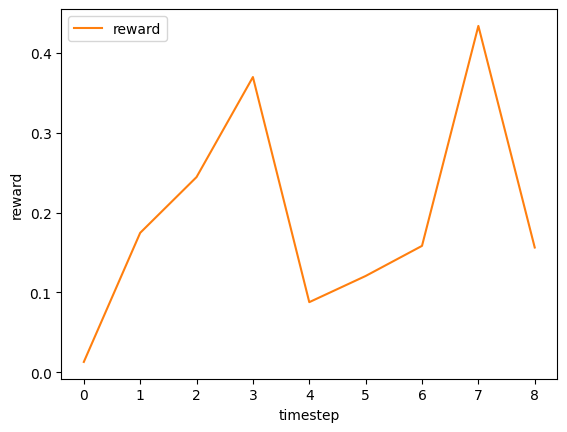

In [17]:
# ランダムエージェントの報酬の推移を可視化
def visualize_interaction_on_environment(env, agent):
    obs, info = env.reset()
    done = False
    reward_list = []

    while not done:
        action = agent.sample_action_online(obs)
        obs, reward, done, truncated, info = env.step(action)
        reward_list.append(reward)

    # プロット
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(reward_list[:-1], label='reward', color='tab:orange')
    ax1.set_xlabel('timestep')
    ax1.set_ylabel('reward')
    ax1.legend(loc='upper left')
    plt.show()
    
visualize_interaction_on_environment(env, agent)

## 2. 標準的な環境設定

SCOPE-RLでは，以下の標準的な環境を設定しています．

In [18]:
env = gym.make('RECEnv-v0')

## 3. 環境設定のカスタマイズ
以下では、シミュレーション環境をカスタマイズする方法を解説します．

環境には以下の変数があります．
- `step_per_episode`: 一つのエピソードでの意思決定の数
- `n_items`: 推薦システムでのアイテムの数
- `n_users`: 推薦システムでのユーザーの数
- `item_feature_dim`: アイテム特徴量の次元
- `user_feature_dim`: ユーザー特徴量の次元
- `item_feature_vector`: それぞれのアイテムの特徴量（ベクトル）
- `user_feature_vector`: それぞれのユーザーの特徴量（ベクトル）
- `reward_type`: 報酬のタイプ
- `reward_std`: 報酬のノイズの大きさ (reward_typeが"continuous"の場合のみ)
- `obs_std`: 状態観測のノイズの大きさ
- `StateTransitionFunction`: 状態遷移関数
- `UserModel`: ユーザーモデル (ユーザーの嗜好の推移と報酬関数を定義)
- `random_state` : ランダムシード

#### ケース 1. 一般的な環境パラメタのカスタマイズ

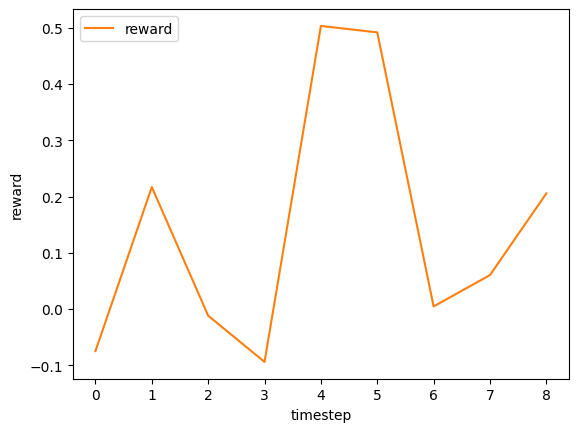

In [19]:
env = RECEnv(
    step_per_episode=10,
    n_items=100,
    n_users=100,
    item_feature_dim=5,
    user_feature_dim=5,
    reward_type="continuous",  # "binary"
    reward_std=0.3,
    obs_std=0.3,
    random_state=12345,
)
visualize_interaction_on_environment(env, agent)

#### ケース 2. アイテムとユーザーのカスタマイズ

In [20]:
# 下のようなアイテムを推薦
item_features = np.sign(random_.normal(size=(100, 5))).astype(int)
item_names, feature_names = [f"ad{i+1}" for i in range(100)], [f"feature{i+1}" for i in range(5)]
item_df = pd.DataFrame(item_features, columns=feature_names, index=item_names)
item_df

,feature1,feature2,feature3,feature4,feature5
ad1,-1,1,-1,-1,1
ad2,1,1,1,1,1
ad3,1,-1,1,1,1
ad4,1,-1,-1,1,-1
ad5,-1,1,1,-1,-1
...,...,...,...,...,...
ad96,1,-1,-1,-1,1
ad97,1,1,-1,1,1
ad98,-1,-1,1,1,-1
ad99,-1,1,-1,1,1


In [21]:
# 下の100人のユーザーを仮定
user_features = np.sign(random_.normal(size=(100, 5))).astype(int)
user_names, feature_names = [f"user{i+1}" for i in range(100)], [f"feature{i+1}" for i in range(5)]
user_df = pd.DataFrame(user_features, columns=feature_names, index=user_names)
user_df

,feature1,feature2,feature3,feature4,feature5
user1,-1,-1,-1,1,1
user2,-1,-1,1,1,-1
user3,-1,-1,1,1,-1
user4,1,1,1,1,1
user5,-1,-1,1,1,1
...,...,...,...,...,...
user96,-1,-1,-1,-1,1
user97,1,-1,1,1,-1
user98,1,-1,1,-1,-1
user99,-1,1,-1,1,-1


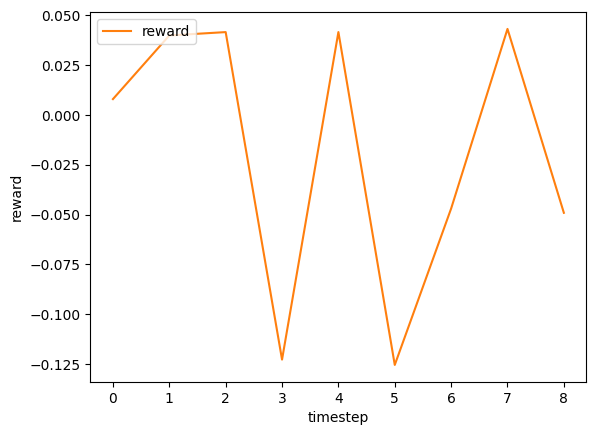

In [22]:
# 上のデータを利用し, 推薦システムをシミュレーション
env = RECEnv(
        n_items=100,
        n_users=100,
        item_feature_dim=5,
        user_feature_dim=5,
        item_feature_vector=item_features,
        user_feature_vector=user_features,
        random_state = 12345,
)
visualize_interaction_on_environment(env, agent)

#### ケース 3. ユーザー行動モデルのカスタマイズ

In [23]:
@dataclass
class CustomizedUserModel(BaseUserModel):
    user_feature_dim: int
    item_feature_dim: int
    reward_type: str = "continuous"  # "binary"
    reward_std: float = 0.0
    random_state: Optional[int] = None

    def __post_init__(self):
        self.random_ = check_random_state(self.random_state)
        self.coef = self.random_.normal(size=(self.user_feature_dim, self.item_feature_dim))

    def user_preference_dynamics(
        self,
        state: np.ndarray,
        action: Union[int, np.ndarray],
        item_feature_vector: np.ndarray,
        alpha: float = 1.0,
    ) -> np.ndarray:
        coefficient = state.T @ self.coef @ item_feature_vector[action]
        state = state + alpha * coefficient * item_feature_vector[action]
        state = state / np.linalg.norm(state, ord=2)
        return state

    def reward_function(
        self,
        state: np.ndarray,
        action: Union[int, np.ndarray],
        item_feature_vector: np.ndarray,
    ) -> float:
        logit = state.T @ self.coef @ item_feature_vector[action]
        reward = (
            logit if self.reward_type == "continuous" else sigmoid(logit)
        )

        if self.reward_type == "discrete":
            reward = self.random_.binominal(1, p=reward)

        return reward

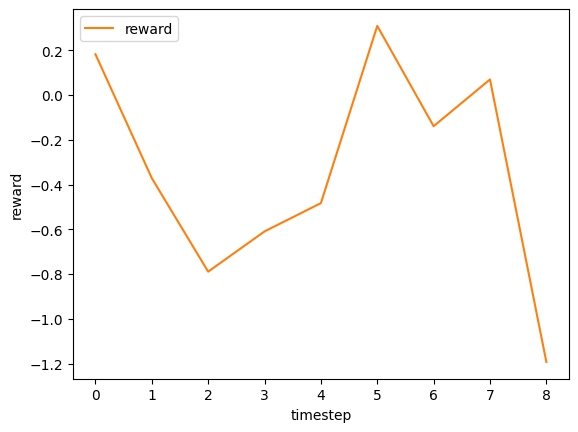

In [24]:
# 環境を設定
env = RECEnv(
    UserModel=CustomizedUserModel,
    random_state=12345
)
visualize_interaction_on_environment(env, agent)

データ生成や可視化は以下を参照してください． [examples/quickstart_ja/rec/rec_synthetic_data_collection_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rec/rec_synthetic_data_collection_ja.ipynb). 

オフライン強化学習やオフ方策評価 (OPE) に関しては以下を参照してください [examples/quickstart_ja/rec/rec_synthetic_discrete_basic_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rec/rec_synthetic_discrete_basic_ja.ipynb).

OPEのより発展的なトピック(累積分布関数の推定など) やオフ方策選択 (OPS) は，以下を参照してください. [examples/quickstart_ja/rec/rec_synthetic_discrete_advanced_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rec/rec_synthetic_discrete_advanced_ja.ipynb).

## 参考文献
- Sarah Dean and Jamie Morgenstern. \
"Preference Dynamics Under Personalized Recommendations.", 2022.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- David Rohde, Stephen Bonner, Travis Dunlop, Flavian Vasile, Alexandros Karatzoglou. \
"RecoGym: A Reinforcement Learning Environment for the Problem of Product Recommendation in Online Advertising." 2018.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.